In [1]:
import numpy as np
import pandas as pd
import lmfit
import matplotlib.pyplot as plt

from typing import Union

from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

In [2]:
raw_data = pd.read_csv('data/covid_19_data.csv')
raw_data['ObservationDate'] = pd.to_datetime(raw_data['ObservationDate'], format='%m/%d/%Y')
time_series_per_country = raw_data.groupby(['Country/Region', 'ObservationDate']).agg(
    {'Confirmed':sum, 'Deaths': sum, 'Recovered': sum}
)


def get_SIR_data(country_name, n):
    filtered_df = time_series_per_country.iloc[time_series_per_country.index.get_level_values('Country/Region') == country_name]
    filtered_df = filtered_df.reset_index(level=0, drop=True) # remove country's name from index
    filtered_df['R'] = (filtered_df.pop('Deaths') + filtered_df.pop('Recovered'))
    filtered_df['I'] = filtered_df.pop('Confirmed') - filtered_df['R']
    filtered_df['S'] = n - filtered_df['I'] - filtered_df['R']
    return filtered_df


## SIR моделът с константни коефициенти

$$\begin{eqnarray}
\frac{dS}{dt} &=& -\frac{\beta}{\color{red}N}SI \\
\frac{dI}{dt} &=& \frac{\beta}{N}SI - \gamma I \\
\frac{dR}{dt} &=& \gamma I \\
\end{eqnarray}$$

Нека за начало да видим динамиката на модела за различни стойности на $\beta$, $\gamma$ и съответно $R_0 = \frac{\beta}{\gamma}$.

Да разгледаме популация от 1000 души за период от 160 дена с 1 заразен индивид в началото:

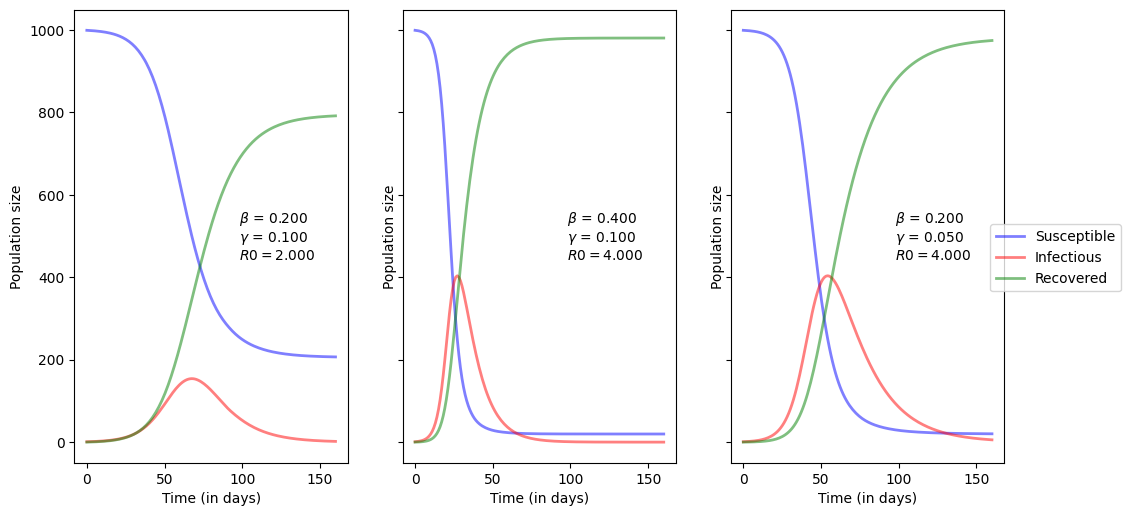

In [3]:
class SIRData:

    def __init__(self, times, S, I, R, N, beta, gamma):
        self.S = S
        self.I = I
        self.R = R
        self.N = N
        self.t = times
        self.beta = beta
        self.gamma = gamma

    @property
    def _params_text(self) -> str:
        return '\n'.join([
            r'$\beta$ = {:.3f}'.format(self.beta),
            r'$\gamma$ = {:.3f}'.format(self.gamma),
            r'$R0 = {:.3f}$'.format(self.beta / self.gamma)
        ])

    def subplot(self, ax, S=True, I=True, R=True, text_position=(0.6, 0.5), title=None):
        if S:
            ax.plot(self.t, self.S, 'b', alpha=0.5, lw=2, label='Susceptible')
        if I:
            ax.plot(self.t, self.I, 'r', alpha=0.5, lw=2, label='Infectious')
        if R:
            ax.plot(self.t, self.R, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.set_xlabel('Time (in days)')
        ax.set_ylabel('Population size')
        ax.text(
            *text_position, self._params_text,
            horizontalalignment='left',
            verticalalignment='center',
            transform = ax.transAxes
        )
        if title:
            ax.set_title(title)

    def plot(self, num=None, scale='linear', title=None):
        plt.figure(num=num, dpi=100)
#         plt.plot(self.t, self.S, 'b', alpha=0.5, lw=2, label='Susceptible')
        plt.plot(self.t, self.I, 'r', alpha=0.5, lw=2, label='Infectious')
#         plt.plot(self.t, self.R, 'g', alpha=0.5, lw=2, label='Recovered')
        plt.xlabel('Time (in days)')
        plt.ylabel('Population size')
        plt.yscale(scale)
        plt.figtext(.67, .74, self._params_text)
        if title:
            plt.title(title)
        plt.legend()
        plt.show()


class SIRModel:

    def __init__(self, initial_conditions: tuple, **params):
        self.initial_conditions = initial_conditions

    @classmethod
    def _get_data_type(cls):
        return SIRData

    @staticmethod
    def _ode(t, y, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    def _solve(self, times: np.ndarray, *args):
        solution = solve_ivp(
            self._ode, (times[0], times[-1]), self.initial_conditions,
            args=args, dense_output=True
        )
        return solution.sol(times)

    def solve(self, times: np.ndarray, *args):
        result = self._solve(times, *args)
        wrapper = self._get_data_type()
        return wrapper(times, *result, *args)
    
    def fit(self, S_obs, I_obs, R_obs, initial_guess=None):
        times = np.array(range(len(I_obs)))
        N = S_obs[0] + I_obs[0] + R_obs[0]
        observed_data = np.array([S_obs, I_obs, R_obs]).flatten()
#         gamma = 1./14

        def target(t, beta, gamma):
            return self._solve(t, N, beta, gamma).flatten()

        model = lmfit.Model(target)
        model.set_param_hint("beta", value=0.2, vary=True)
        model.set_param_hint("gamma", value=1./14, vary=True)
        params = model.make_params()
        result = model.fit(observed_data, params, method="leastsq", t=times)  # fitting
        beta = result.best_values['beta']
        gamma = result.best_values['gamma']
        return self.solve(times, N, beta, gamma)
#         popt, pcov = curve_fit(target, times, observed_data)
#         print(popt)
#         return self.solve(times, N=N, beta=popt[0], gamma=1./14)#popt[1])


# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# A grid of time points (in days)
t = np.linspace(0, 160, 160)
# Initial conditions vector
y0 = S0, I0, R0

fig, (ax_l, ax_c, ax_r) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, dpi=100, figsize=(12,6))

SIRModel(y0).solve(t, N, 0.2, 1./10).subplot(ax_l)
SIRModel(y0).solve(t, N, 0.4, 1./10).subplot(ax_c)
SIRModel(y0).solve(t, N, 0.2, 1./20).subplot(ax_r)

handles, labels = ax_r.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.show()

## Параметрична идентификация (константни коефициенти)

Сега да се опитаме да направим параметрична идентификация на модела относто $\beta$ и $\gamma$ спрямо данните за разпространението на Covid-19 в различни страни.

Това ще ни позволи да оценим и $R_0 = \frac{\beta}{\gamma}$, което както разбрахме играе ключова роля за динамиката на епидемията.
 

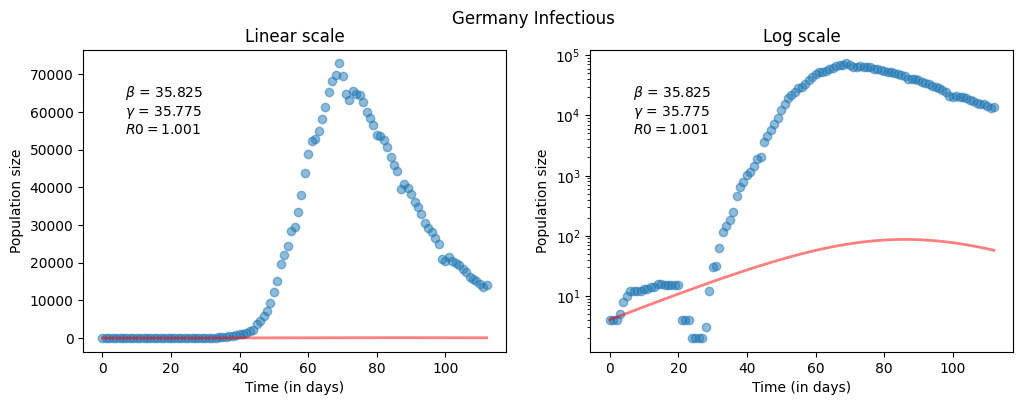

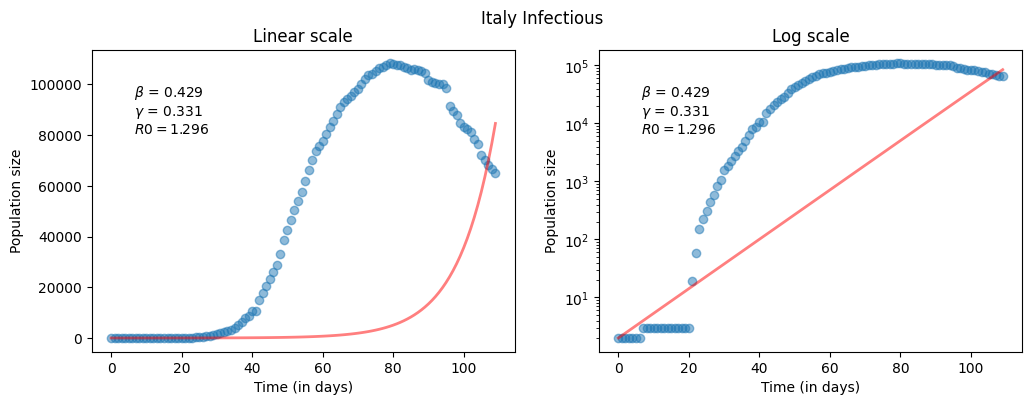

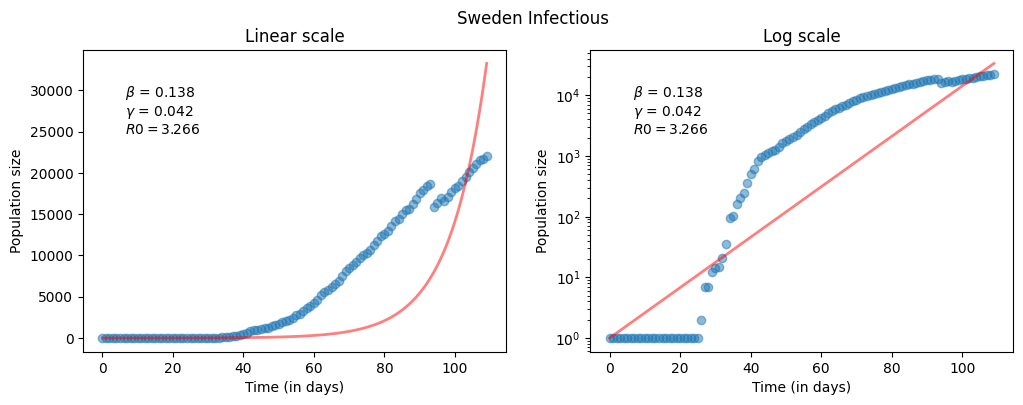

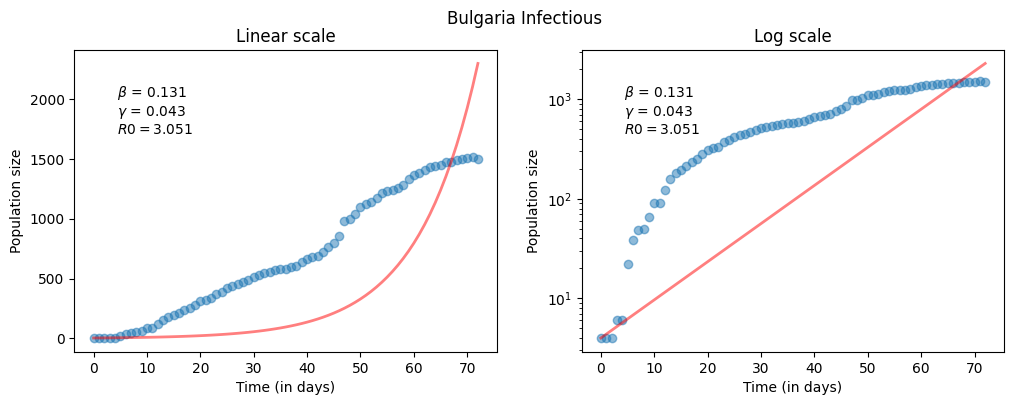

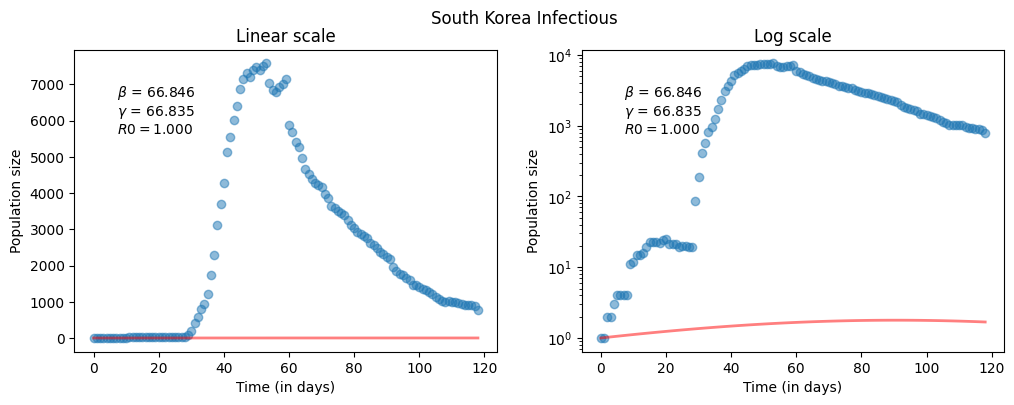

In [4]:
def fit_sir(country_name: str, population_size: int, model=SIRModel, initial_guess=None, plot_R=False):
    data = get_SIR_data(country_name, population_size)
    S, I, R = data['S'], data['I'], data['R']

#     if outbreak_shift > 0: # maybe makes sense only when fitting dR/dt only
#         S = np.concatenate((np.array([S[0]-1]*outbreak_shift), S))
#         I = np.concatenate((np.array([1]*outbreak_shift), I))
#         R = np.concatenate((np.zeros(outbreak_shift), R))

    fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(12,4))
    # plot data (left - linear scale):
    ax_l.plot(np.array(range(len(I))), I, 'o', alpha=0.5, lw=2, label='Infectious (observed)')
    # plot data (right - log scale)
    ax_r.set_yscale('log')
    ax_r.plot(np.array(range(len(I))), I, 'o', alpha=0.5, lw=2, label='Infectious (observed)')

    fitted_data = model((S[0], I[0], R[0])).fit(S, I, R, initial_guess=initial_guess)
    # plot fit (left - linear scale):
    fitted_data.subplot(ax_l, S=False, R=False, text_position=(0.1, 0.8), title='Linear scale')
    # plot fit (right - linear scale):
    fitted_data.subplot(ax_r, S=False, R=False, text_position=(0.1, 0.8), title='Log scale')
    
    if plot_R:
        fig2, (ax2_l, ax2_r) = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(12,4))
        ax2_l.plot(np.array(range(len(R))), R, 'o', alpha=0.5, lw=2, label='Recovered (observed)')
        ax2_r.set_yscale('log')
        ax2_r.plot(np.array(range(len(R))), R, 'o', alpha=0.5, lw=2, label='Recovered (observed)')
        # plot fit (left - linear scale):
        fitted_data.subplot(ax2_l, S=False, I=False, text_position=(0.1, 0.8), title='Linear scale')
        # plot fit (right - linear scale):
        fitted_data.subplot(ax2_r, S=False, I=False, text_position=(0.1, 0.8), title='Log scale')
        fig2.suptitle(country_name + ' Recovered')

    fig.suptitle(country_name + ' Infectious')
    plt.show()

fit_sir('Germany', 83754192)
fit_sir('Italy', 60461826)
fit_sir('Sweden', 10099265)
fit_sir('Bulgaria', 7000000)
fit_sir('South Korea', 51269185)

{'gamma': 0.06444697929210576, 'R0_start': 3.404723338937137, 'R0_end': 0.4540762647068892, 'x0': 65.05350889834574, 'k': 0.23182109346196167}


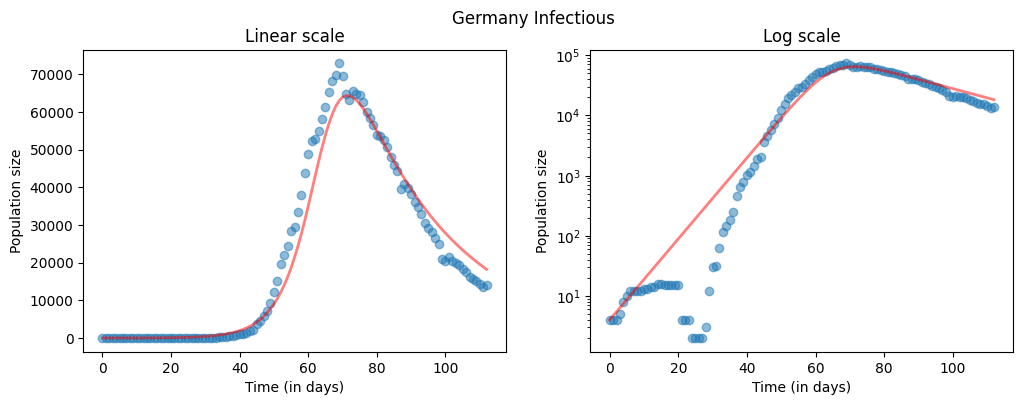

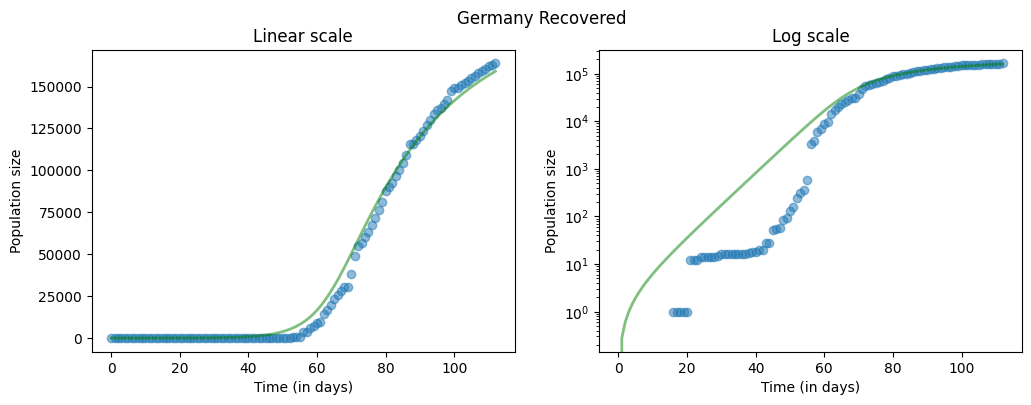

{'gamma': 0.02735751050006665, 'R0_start': 11.451740413656962, 'R0_end': 0.2669881994111461, 'x0': 40.90592950350161, 'k': 0.07113334756865484}


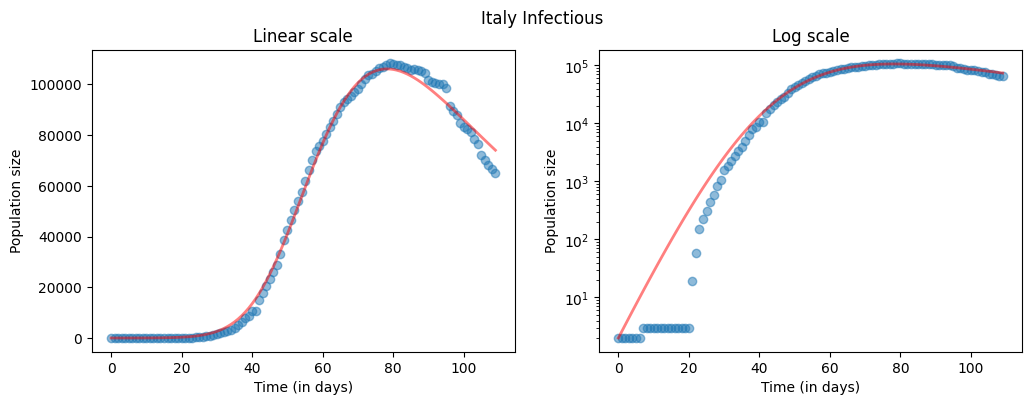

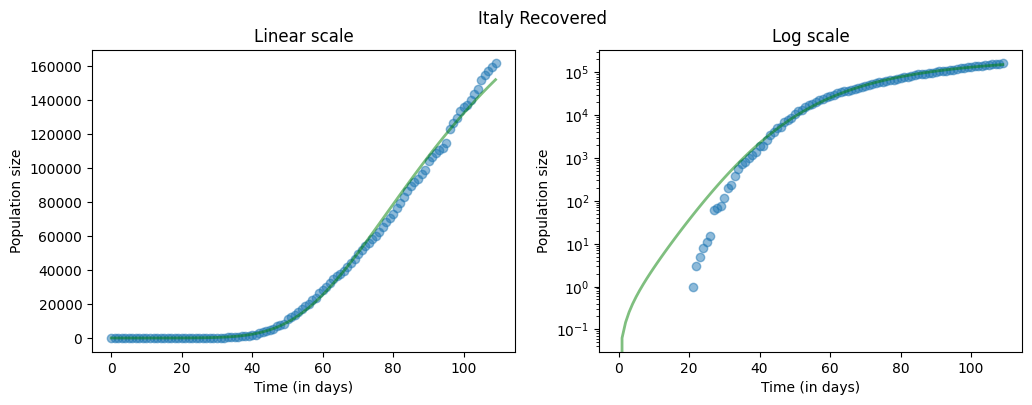

{'gamma': 0.013516255042053445, 'R0_start': 12.57800869454677, 'R0_end': 1.7413757863639119, 'x0': 60.76293918464825, 'k': 0.08943118126921798}


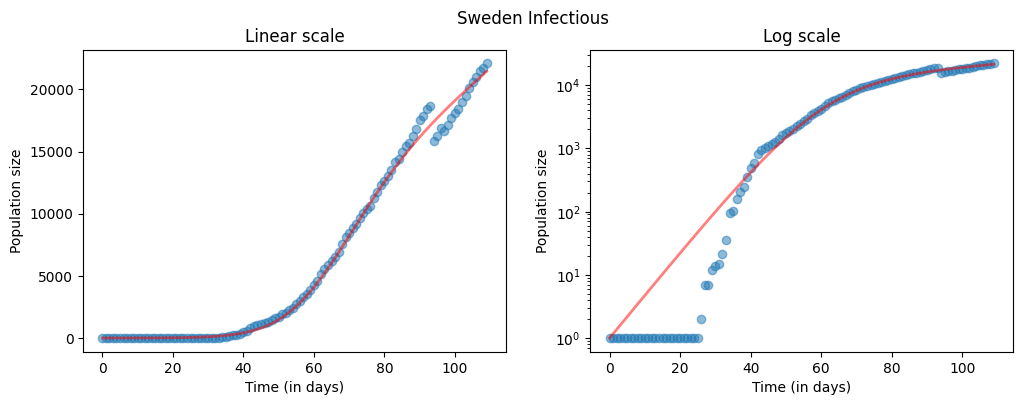

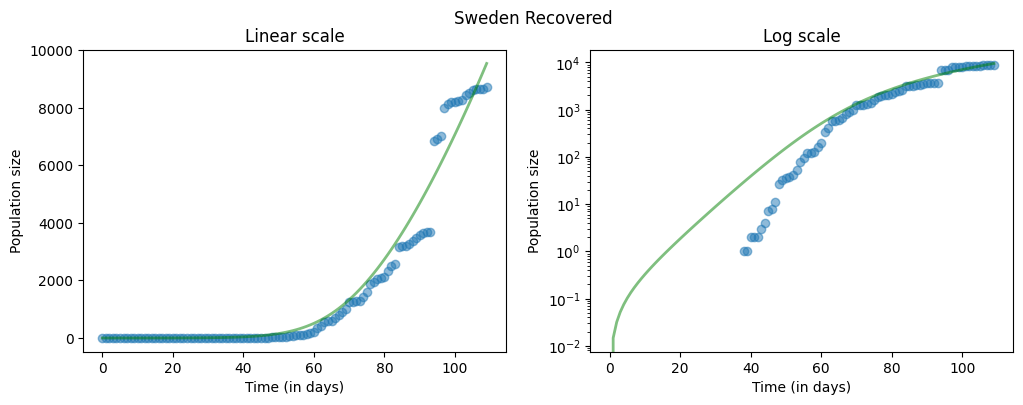

{'gamma': 0.03291580063138598, 'R0_start': 7.210795331116034, 'R0_end': 0.24615225444055175, 'x0': 43.99518374858952, 'k': 0.37082461357941315}


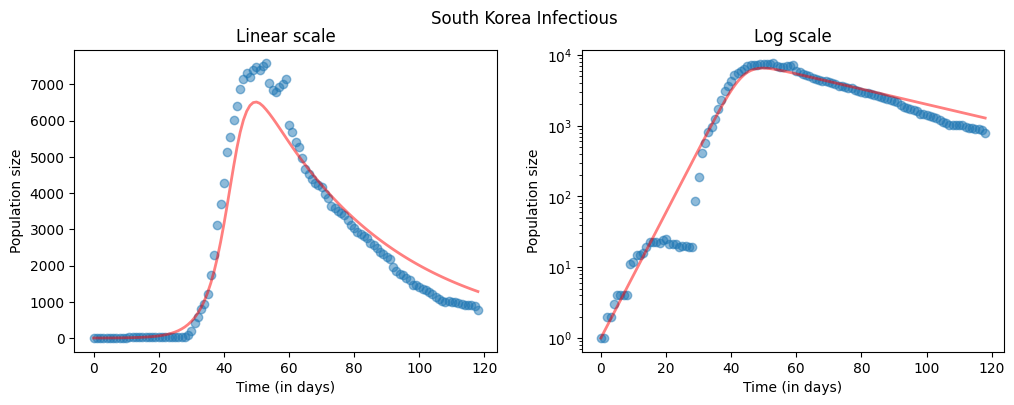

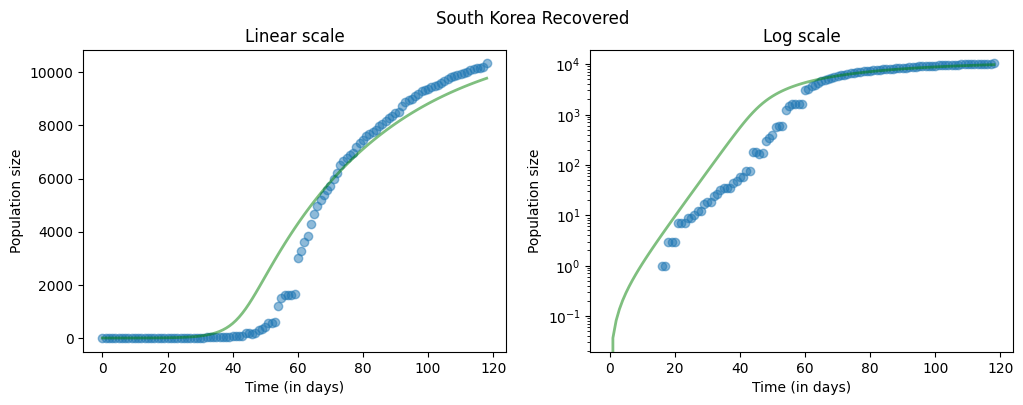

In [5]:
class SIRDataLogisticR0(SIRData):
    
    def __init__(self, times, S, I, R, N, gamma, R0_start, R0_end, x0, k):
        super().__init__(times, S, I, R, N, None, gamma)

    @property
    def _params_text(self) -> str:
        return ''
#         return '\n'.join([
#             r'$\beta$ = {:.3f}'.format(self.beta),
#             r'$\gamma$ = {:.3f}'.format(self.gamma),
#             r'$R0 = {:.3f}$'.format(self.beta / self.gamma)
#         ])


class SIRModelLogisticR0(SIRModel):
    
    GAMMA = 1./20#1./14
    
    @classmethod
    def _get_data_type(cls):
        return SIRDataLogisticR0

    @staticmethod
    def _ode(t, y, N, gamma, R0_start, R0_end, x0, k):

        def logistic_R_0(t):
#             R_0_start = 3.185
#             R_0_end = 0.43
#             x0 = 65
            return (R0_start-R0_end) / (1 + np.exp(-k*(-t+x0))) + R0_end

        def beta(t):
            return logistic_R_0(t) * gamma

        S, I, R = y
        dSdt = -beta(t) * S * I / N
        dIdt = beta(t) * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    def fit(self, S_obs, I_obs, R_obs, initial_guess=None) -> SIRData:
        times = np.array(range(len(I_obs)))
        N = S_obs[0] + I_obs[0] + R_obs[0]
        observed_data = np.array([S_obs, I_obs, R_obs]).flatten()
#         observed_data = np.array([I_obs]).flatten()

        def target(t, gamma, R0_start, R0_end, x0, k):
            return self._solve(t, N, gamma, R0_start, R0_end, x0, k).flatten()

        model = lmfit.Model(target)
        if initial_guess:
            for param_name, value in initial_guess.items():
                model.set_param_hint(param_name, value=value, vary=True)
        params = model.make_params()
        result = model.fit(observed_data, params, method="leastsq", t=times)  # fitting
        popt = result.best_values
        print(popt)
        return self.solve(
            times, N, popt['gamma'],
            popt['R0_start'], popt['R0_end'], popt['x0'], popt['k']
        )


fit_sir(
    'Germany', 83754192,
    model=SIRModelLogisticR0, plot_R=True,
    initial_guess={'R0_start': 3.5, 'R0_end': 0.5, 'x0': 60, 'k': 0.5, 'gamma': 1./14}
)
fit_sir(
    'Italy', 60461826,
    model=SIRModelLogisticR0, plot_R=True,
    initial_guess={'R0_start': 5, 'R0_end': 0.5, 'x0': 30, 'k': 0.5, 'gamma': 1./14}
)
fit_sir(
    'Sweden', 10099265,
    model=SIRModelLogisticR0, plot_R=True,
    initial_guess={'R0_start': 5, 'R0_end': 0.5, 'x0': 30, 'k': 0.5, 'gamma': 1./14}
)
# fit_sir(
#     'Bulgaria', 7000000,
#     model=SIRModelLogisticR0, plot_R=True,
#     initial_guess={'R0_start': 3, 'R0_end': 1, 'x0': 10, 'k': 0.05, 'gamma': 1./14}
# )
fit_sir(
    'South Korea', 51269185,
    model=SIRModelLogisticR0, plot_R=True,
    initial_guess={'R0_start': 5, 'R0_end': 0.5, 'x0': 30, 'k': 0.5, 'gamma': 1./14}
)

TypeError: solve() got an unexpected keyword argument 'N'

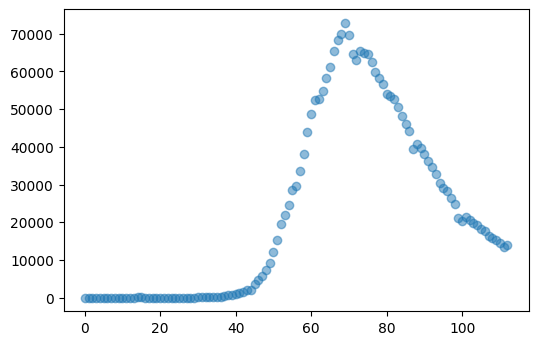

In [6]:
germany_N = 83754192

data = get_SIR_data('Germany', germany_N)
S, I, R = data['S'], data['I'], data['R']

plt.figure(num=1, dpi=100)
plt.plot(np.array(range(len(I))), I, 'o', alpha=0.5, lw=2, label='Infectious (observed)')

# SIRModel((germany_N, I[0], 0.0)).fit(S, I, R).plot(num=1, scale='linear')
SIRModel((germany_N, I[0], 0.0)).solve(t, N=germany_N, beta=lambda t: 0.216 if t < 68 else 0.035, gamma=1./14).plot(num=1, scale='log')
print('R0 before 2020-04-05: ', 0.216 / 0.07142857142857142)
print('R0 after  2020-04-05: ', 0.035 / 0.07142857142857142)

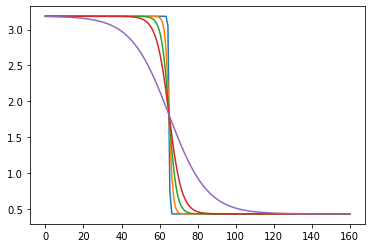

In [7]:
# plt.figure(num=2, dpi=100)
# plt.plot(np.array(range(len(I))), I, 'o', alpha=0.5, lw=2, label='Infectious (observed)')

def logistic_R_0(t, k=0.3):
    R_0_start = 3.185
    R_0_end = 0.43
    x0 = 65
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * 1./14


# SIRModel((germany_N, I[0], 0.0)).solve(t, N=germany_N, beta=beta, gamma=1./14).plot(num=2, scale='linear')
plt.plot(t, logistic_R_0(t, k=5))
plt.plot(t, logistic_R_0(t, k=1))
plt.plot(t, logistic_R_0(t, k=0.5))
plt.plot(t, logistic_R_0(t, k=0.3))
plt.plot(t, logistic_R_0(t, k=0.1))
plt.show()

In [ ]:
italy_N = 60461826

data = get_SIR_data('Italy', italy_N)
S, I, R = data['S'], data['I'], data['R']

plt.figure(num=1, dpi=100)
plt.plot(np.array(range(len(I))), I, 'o', alpha=0.5, lw=2, label='Infectious (observed)')

SIRModel((italy_N, I[0], 0.0)).fit(S, I, R).plot(num=1, scale='linear')

In [ ]:
data.index[68]

In [ ]:
np.array([1]*5)

In [ ]:
def test(*args):
    print(args)
    print(type(args))

In [ ]:
1./0.03291580063138598